# Câu hỏi muốn trả lời
Liệu có thể dự đoán thời tiết của 12 tiếng sau bằng cách sử dụng thông tin thời tiết của hiện tại không?

# Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tắt cảnh báo SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram')

from datetime import datetime

# Đọc dữ liệu

In [2]:
raw_weather_df = pd.read_csv('raw_weather_df.csv')
raw_weather_df = raw_weather_df.drop(columns = ['Unnamed: 0'])
raw_weather_df.head()

,time,city_name,temp,pressure,humidity,clouds,wind_speed,weather_description
0,2021-01-09 00:00:00,THU DAU MOT,24.0,1011,69,20,1.54,few clouds
1,2021-01-09 01:00:00,THU DAU MOT,25.0,1012,65,98,1.54,overcast clouds
2,2021-01-09 02:00:00,THU DAU MOT,26.0,1012,65,20,1.03,few clouds
3,2021-01-09 03:00:00,THU DAU MOT,28.0,1012,57,20,2.57,few clouds
4,2021-01-09 04:00:00,THU DAU MOT,29.0,1011,51,20,1.54,few clouds


# Khám phá dữ liệu

Ý nghĩa các trường dữ liệu, theo như link API: https://openweathermap.org/api/one-call-api#list1
- time: thời gian phép đo đạc được thực hiện, tính theo giờ
- city_name: Thành phố nơi các số đo thời thiết được ghi nhận
- temp: nhiệt độ 
- pressure: áp suất không khí
- humidity: độ ẩm
- cloud: mật độ mây
- wind_speed: tốc độ gió
- weather description: đặc tả thời tiết, chi tiết các đặc tả này có thể xem tại https://openweathermap.org/weather-conditions#Weather-Condition-Codes-2

## Xem số dòng và số cột

In [3]:
raw_weather_df.shape

(1560, 8)

## Kiểm tra xem có bị lặp dòng nào không?

In [4]:
raw_weather_df.index.duplicated().sum()

0

## Xem tổng quan thông tin các trường dữ liệu

In [5]:
raw_weather_df.describe()

,temp,pressure,humidity,clouds,wind_speed
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,24.781160,1011.043590,67.594872,32.158974,2.270968
std,3.372387,1.617146,17.125578,24.656363,1.207018
min,17.000000,1007.000000,35.000000,0.000000,0.270000
25%,22.000000,1010.000000,54.000000,20.000000,1.540000
50%,24.000000,1011.000000,68.000000,20.000000,2.060000
75%,27.000000,1012.000000,78.000000,40.000000,3.090000
max,32.610000,1015.000000,100.000000,100.000000,8.530000


In [6]:
raw_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 1560 non-null   object 
 1   city_name            1560 non-null   object 
 2   temp                 1560 non-null   float64
 3   pressure             1560 non-null   int64  
 4   humidity             1560 non-null   int64  
 5   clouds               1560 non-null   int64  
 6   wind_speed           1560 non-null   float64
 7   weather_description  1560 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 97.6+ KB


Dữ liệu được lấy bằng API nên có vẻ đầy đủ

## Xem quan hệ và phân bố của các trường số

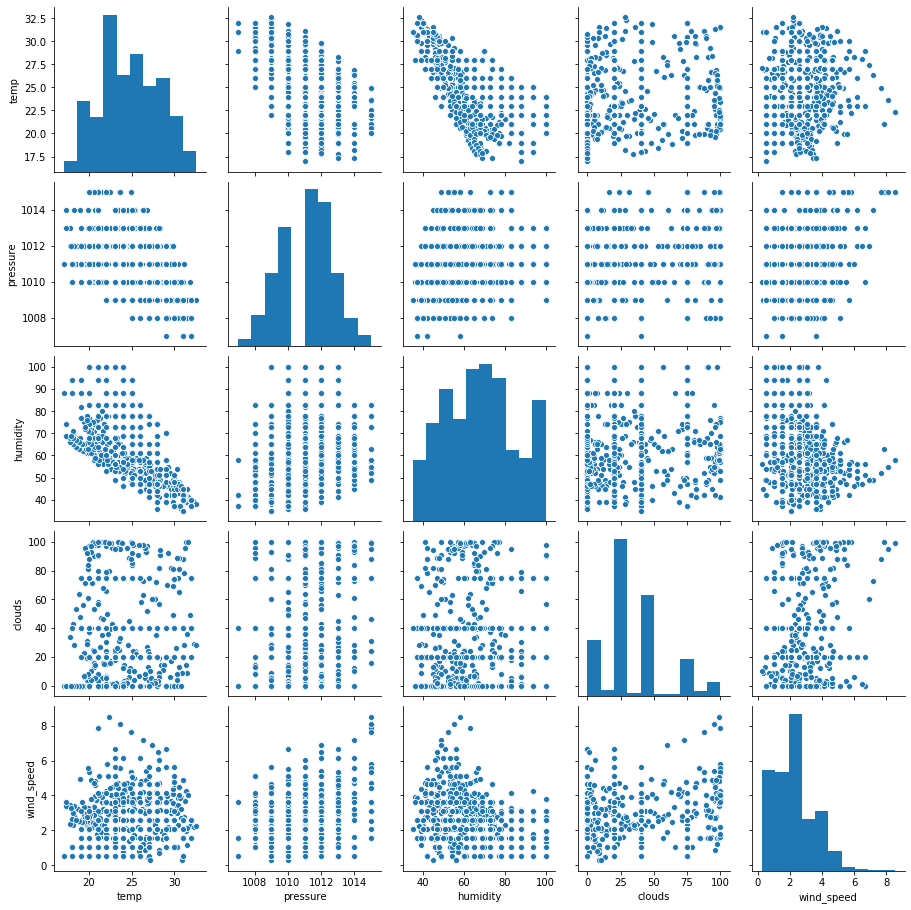

In [7]:
col = ['temp','pressure','humidity','clouds','wind_speed']
sns.pairplot(raw_weather_df[col])

# Tiền xử lí dữ liệu

## Tạo cột output

Vì mục tiêu của tụi mình là xem thử có thể dùng dữ liệu thời tiết hiện tại để dự đoán trước 12 tiếng không nên mình sẽ thực hiện tạo thêm một cột weather_description_12 là cột output để lưu mô tả thời tiết của 12 tiếng sau  

In [8]:
raw_weather_df.insert(len(raw_weather_df.columns), "weather_description_12", "")
raw_weather_df.head()

,time,city_name,temp,pressure,humidity,clouds,wind_speed,weather_description,weather_description_12
0,2021-01-09 00:00:00,THU DAU MOT,24.0,1011,69,20,1.54,few clouds,
1,2021-01-09 01:00:00,THU DAU MOT,25.0,1012,65,98,1.54,overcast clouds,
2,2021-01-09 02:00:00,THU DAU MOT,26.0,1012,65,20,1.03,few clouds,
3,2021-01-09 03:00:00,THU DAU MOT,28.0,1012,57,20,2.57,few clouds,
4,2021-01-09 04:00:00,THU DAU MOT,29.0,1011,51,20,1.54,few clouds,


In [9]:
for row in range(0,raw_weather_df.shape[0]):
#     raw_weather_df['weather_description_12'][row+12] = raw_weather_df['weather description'][row]
     raw_weather_df.loc[row-12,'weather_description_12'] = raw_weather_df['weather_description'][row]
raw_weather_df

,time,city_name,temp,pressure,humidity,clouds,wind_speed,weather_description,weather_description_12
0,2021-01-09 00:00:00,THU DAU MOT,24.0,1011.0,69.0,20.0,1.54,few clouds,scattered clouds
1,2021-01-09 01:00:00,THU DAU MOT,25.0,1012.0,65.0,98.0,1.54,overcast clouds,scattered clouds
2,2021-01-09 02:00:00,THU DAU MOT,26.0,1012.0,65.0,20.0,1.03,few clouds,scattered clouds
3,2021-01-09 03:00:00,THU DAU MOT,28.0,1012.0,57.0,20.0,2.57,few clouds,scattered clouds
4,2021-01-09 04:00:00,THU DAU MOT,29.0,1011.0,51.0,20.0,1.54,few clouds,scattered clouds
...,...,...,...,...,...,...,...,...,...
-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,few clouds
-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scattered clouds
-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scattered clouds
-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scattered clouds


Khi làm cách này ta sẽ bị dư ra bao gồm 24 dòng, bao gồm 12 dòng rỗng và 12 dòng cuối của dataframe mà cột weather_description_12 không có dữ liệu, chỉ việc bỏ các cột này

In [10]:
raw_weather_df = raw_weather_df.dropna()
raw_weather_df = raw_weather_df[raw_weather_df['weather_description_12'] != '']

Ngoài ta ta sẽ cần loại bỏ 12 dòng cuối của mỗi thành phố vì chúng lẫn với thời tiết thành phố khác

In [11]:
weather_df = raw_weather_df[raw_weather_df['time'] <= '2021-01-13 11:00:00']

Để chuyển đổi cột output sang dạng số, tụi mình cần xem thử cột có những giá trị nào, nhưng sẽ không xem tỉ lệ của cụ thể từng giá trị để tránh làm mất tính khách quan của tập dữ liệu

In [12]:
nunique_weather = weather_df['weather_description_12'].nunique()
print(nunique_weather)
unique_weather = weather_df['weather_description_12'].unique()
print(unique_weather)

5
['scattered clouds' 'broken clouds' 'few clouds' 'clear sky'
 'overcast clouds']


## Tách tập train, validate và test

In [13]:
Y = weather_df['weather_description_12']
X = weather_df.drop(columns = ['weather_description_12'])

In [14]:
X.shape

(1404, 8)

In [15]:
Y.shape

(1404,)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 13)

print("X train shape: {}, X test shape: {}".format(X_train.shape,X_test.shape))
print("Y train shape: {}, Y test shape: {}".format(Y_train.shape,Y_test.shape))

X train shape: (1123, 8), X test shape: (281, 8)
Y train shape: (1123,), Y test shape: (281,)


## Khám phá lại dữ liệu huấn luyện để tiền xử lí

### Kiểu dữ liệu

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1123 entries, 1461 to 374
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 1123 non-null   object 
 1   city_name            1123 non-null   object 
 2   temp                 1123 non-null   float64
 3   pressure             1123 non-null   float64
 4   humidity             1123 non-null   float64
 5   clouds               1123 non-null   float64
 6   wind_speed           1123 non-null   float64
 7   weather_description  1123 non-null   object 
dtypes: float64(5), object(3)
memory usage: 79.0+ KB


### Xem thử cột weather_description	 có những giá trị nào

In [18]:
print(X_train['weather_description'].nunique())
label_weight = dict((X_train['weather_description'].value_counts(normalize=True)*100).round(2))
print(label_weight)

5
{'few clouds': 42.12, 'scattered clouds': 30.19, 'broken clouds': 11.93, 'clear sky': 11.22, 'overcast clouds': 4.54}


Có vẻ là lấy thời gian khá gần nên thời tiết chủ đạo ở miền nam trong thời gian này là có mây các dạng: ít mấy, mây rải rác, mây vỡ hoặc nhiều mây hoặc trời trong xanh

In [19]:
X_train.head()

,time,city_name,temp,pressure,humidity,clouds,wind_speed,weather_description
1461,2021-01-09 21:00:00,CAN GIO,23.0,1009.0,73.0,40.0,1.54,scattered clouds
408,2021-01-11 00:00:00,TAN AN,22.0,1011.0,78.0,20.0,2.06,few clouds
1355,2021-01-10 11:00:00,CAN THO,26.0,1010.0,83.0,75.0,2.06,broken clouds
120,2021-01-09 00:00:00,THANH PHO HO CHI MINH,24.0,1011.0,69.0,20.0,1.54,few clouds
0,2021-01-09 00:00:00,THU DAU MOT,24.0,1011.0,69.0,20.0,1.54,few clouds


## Tiếp tục tiền xử lí

Các bước tiền xử lí:
- Bỏ đi cột city name vì thời tiết của các tỉnh miền nam khá giống nhau nên giữ không có ý nghĩa
- Cột thời gian mình rút gọn chỉ lấy giờ, bởi vì chúng mình dự đoán dựa vào dữ liệu của 12 giờ trước nên mình nghĩ 12 giờ trước đang là thời gian nào ngày cũng khá quan trọng
- Cột weather_description tụi mình sẽ OneHotEncoder
- Cuối cùng là chuẩn hóa sau khi các cột đã có dạng số

### Bỏ cột city name, chuyển cột thời gian sang giờ

In [20]:
class DropCol(BaseEstimator, TransformerMixin):
    def _init_(self):
        return self
    def fit(self, X, Y=None):
        return self
    def transform(self, X, Y=None):
        temp_X_df = X.copy()
        temp_X_df = temp_X_df.drop(columns = ['city_name'])
        for i in range(len(temp_X_df['time'])):
            temp_X_df['time'].iloc[i] = datetime.strptime(temp_X_df['time'].iloc[i],'%Y-%m-%d %H:%M:%S').hour
        return temp_X_df

In [21]:
transformer = DropCol()
transformer.fit(X_train)
processed_X_train_df = transformer.transform(X_train)
processed_X_train_df

,time,temp,pressure,humidity,clouds,wind_speed,weather_description
1461,21,23.0,1009.0,73.0,40.0,1.54,scattered clouds
408,0,22.0,1011.0,78.0,20.0,2.06,few clouds
1355,11,26.0,1010.0,83.0,75.0,2.06,broken clouds
120,0,24.0,1011.0,69.0,20.0,1.54,few clouds
0,0,24.0,1011.0,69.0,20.0,1.54,few clouds
...,...,...,...,...,...,...,...
962,2,26.0,1011.0,57.0,0.0,4.12,clear sky
814,22,19.0,1011.0,77.0,20.0,1.54,few clouds
74,2,24.0,1014.0,57.0,20.0,3.60,few clouds
188,20,22.0,1011.0,68.0,40.0,2.57,scattered clouds


### Tạo pipeline để tiền xử lí

In [22]:
preprocess_pipe = make_pipeline(DropCol(),
                                make_column_transformer((OneHotEncoder(sparse = False),['weather_description']),
                                                       remainder='passthrough'),
                                StandardScaler())
processed_X_train_df = preprocess_pipe.fit_transform(X_train)
print(processed_X_train_df.shape)
processed_X_train_df

(1123, 11)


array([[-0.3680902 , -0.35549844, -0.85304883, ...,  0.42423779,
         0.25704401, -0.68960332],
       [-0.3680902 , -0.35549844,  1.17226584, ...,  0.72550189,
        -0.57519017, -0.25842311],
       [ 2.71672542, -0.35549844, -0.85304883, ...,  1.02676598,
         1.71345384, -0.25842311],
       ...,
       [-0.3680902 , -0.35549844,  1.17226584, ..., -0.53980731,
        -0.57519017,  1.01853365],
       [-0.3680902 , -0.35549844, -0.85304883, ...,  0.1229737 ,
         0.25704401,  0.16446517],
       [-0.3680902 , -0.35549844, -0.85304883, ...,  0.42423779,
         0.25704401, -0.68960332]])

### Tiền xử lí tập test

In [23]:
processed_X_test_df = preprocess_pipe.fit_transform(X_test)
print(processed_X_test_df.shape)
processed_X_test_df

(281, 11)


array([[-0.40740042, -0.39544734,  1.27521301, ..., -0.7104714 ,
        -0.89042701,  1.27522834],
       [-0.40740042, -0.39544734, -0.78418271, ..., -1.61165617,
         0.15289089,  0.61647066],
       [-0.40740042, -0.39544734, -0.78418271, ..., -0.7104714 ,
         0.15289089,  0.61647066],
       ...,
       [-0.40740042, -0.39544734, -0.78418271, ...,  0.49110828,
         0.15289089, -0.24241594],
       [-0.40740042, -0.39544734,  1.27521301, ..., -1.13102429,
        -0.59233618, -0.24241594],
       [-0.40740042, -0.39544734, -0.78418271, ..., -0.28991851,
         2.35131075,  1.45034114]])

# Mô hình hóa 

## Full pipeline với LogisticRegression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
full_pipeline = make_pipeline(preprocess_pipe,LogisticRegression(multi_class = 'multinomial'))
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropcol', DropCol()),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False),
                                                                   ['weather_description'])])),
                                 ('standardscaler', StandardScaler())])),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial'))])

In [38]:
model = full_pipeline.fit(X_train,Y_train)

### Kết quả dự đoán với tập huấn luyện

In [39]:
train_predict = model.predict(X_train)
model.score(X_train,Y_train)

0.5681211041852182

### Kết quả dự đoán với tập kiểm tra

In [40]:
model.score(X_test,Y_test)

0.501779359430605

### Độ tương quan giữa các nhãn và các trường dữ liệu

In [49]:
model['logisticregression'].coef_

array([[-0.26209925,  0.10383036,  0.32762125, -0.12202067, -0.18333382,
        -0.02213476, -0.18772361, -0.12283337,  0.44170342,  0.20161079,
        -0.1058428 ],
       [ 0.21914939,  0.08247298, -0.03154584,  0.08965051, -0.21818318,
        -0.14884575, -0.55252929,  0.23758466, -0.44088634, -0.20541454,
         0.27516014],
       [ 0.13133613, -0.46890889, -0.11274814,  0.07603788,  0.31641344,
        -0.21523346, -0.00617152,  0.24138041,  0.15942732, -0.71483593,
        -0.15000299],
       [ 0.2694991 ,  0.59752876, -0.69455012,  0.35873992, -0.01679309,
         0.76164655,  1.23509089,  0.68839912, -0.09051834,  0.1784852 ,
        -0.07027767],
       [-0.35788537, -0.31492321,  0.51122285, -0.40240763,  0.10189666,
        -0.37543258, -0.48866647, -1.04453083, -0.06972606,  0.54015448,
         0.05096331]])

Mô hình không thể sử dụng được vì độ tương quan giữa các nhãn và các trường dữ liệu quá thấp dẫn đến kết quả kém

## Full pipeline với naive bayes classifier

In [50]:
from sklearn.naive_bayes import GaussianNB

In [51]:
full_pipeline = make_pipeline(preprocess_pipe,GaussianNB())
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropcol', DropCol()),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False),
                                                                   ['weather_description'])])),
                                 ('standardscaler', StandardScaler())])),
                ('gaussiannb', GaussianNB())])

In [52]:
model = full_pipeline.fit(X_train,Y_train)

### Kết quả dự đoán với tập huấn luyện

In [53]:
model.score(X_train,Y_train)

0.4514692787177204

### Kết quả dự đoán với tập kiểm tra

In [54]:
model.score(X_test,Y_test)

0.38434163701067614

Mô hình với naive bayes có vẻ cũng không sử dụng được

# Tạm kết luận: 
- không thể dự đoán trước thời tiết khi mà chỉ biết được dữ liệu trong một giờ của 12 tiếng trước được

# Nhìn lại đồ án

## Khó khăn
- Lựa chọn mô hình cho bài toán vì tụi em lỡ chọn hướng đi hơi sai nên khó khăn trong việc lựa chọn mô hình và dẫn đến thất bại

## Học được
- Chúng em đã có cơ hội để rèn luyện thêm việc tiền xử lí dữ liệu, tìm hiểu về một số thuật toán phân lớp
- Rèn luyện cách sử dụng pipeline mà nhìn chung em thấy khổ lúc đầu nhưng sướng lúc sau

## Nếu có thêm thời gian
- Chúng em định chọn hướng đi khác bằng cách dùng dữ liệu của 3 ngày trước đó để dự đoán từng trường dữ liệu của ngày hôm nay, rồi lại tiếp tục dùng thuật toán phân lớp tương tự như trên với các trường dữ liệu đã được dự đoán để dự đoán mô tả thời tiết chung của 3 ngày sau đó, nhưng có vẻ khá dài nên không thể làm thêm được